# Multiple Gravity Assist with one DSM (MGA-1DSM)

In this tutorial, we use the {class}`pykep.trajopt.mga_1dsm` to design an interplanetary trajectory. The MGA-1DSM encoding of an interplanetary trajectory models multiple (pre-defined) planetary encounters, and enables for propulsion manovures in the form of one instantaneous $\Delta V$ at any time along each leg.

The specific encoding used, described in the book Chapter {cite:p}`izzo2010global` by Izzo D., is useful as a preliminar mission design tool automating the search for good planetary geometries giving the possibility to design trajectories through a process mimicking natural evolution.

This encoding has also been used in the past to define instances of real-world optimization problems to be used in benchmarking optimization tools suitable for interplanetary mission design.

:::{note}
{class}`pykep.trajopt.mga_1dsm` also implements different (unpublished) encodings for the time of flights, namely called $\alpha$-encoding and $\eta$-encoding which, albeit less studied and creating a more complex fitness landscape, are interesting in multiple ways: a) they show how the encoding influences evolvability in a drastic way b) they allow to box-bound the total trajectory time of flight c) they remove problem knowledge exploitation.

We start, as often, with some fundamental imports:

In [1]:
import pykep as pk
import pygmo as pg
import matplotlib.pyplot as plt

We will study the same trajectory problem tackled in the [Multiple Gravity Assist (MGA)](<./udp_mga_1dsm.ipynb>) notebook. In essence we design an Earth return trajectory visiting Venus in two different epochs and Mars in between:

In [2]:
earth = pk.planet(pk.udpla.jpl_lp("earth"))
venus = pk.planet(pk.udpla.jpl_lp("venus"))
mars = pk.planet(pk.udpla.jpl_lp("mars"))
udp = pk.trajopt.mga_1dsm(
    seq=[
        earth,
        venus,
        mars,
        venus,
        earth
    ],
    tof_encoding = "direct",
    t0=[0, 1000],
    tof=[[30, 200], [30, 300], [30, 350], [30, 300]],
    vinf=[3.0, 5.0],
    add_vinf_dep=False,
    add_vinf_arr=True,
    multi_objective=False,
    orbit_insertion=False,
    eta_bounds=[0.01, 0.9],
    rp_ub=70.0,
)

To solve this problem we will use an adaptive version of differential evolution, even if other meta-heuristic would also be possible. We run the algorithm in mult-start, to get a sense of the fitness landscape and complexity.

In [3]:
prob = pg.problem(udp)
# CMA-ES is also possible
#uda = pg.cmaes(1500, force_bounds=True, sigma0=0.5, ftol=1e-4)
# But we prefer a self adaptive version of differential evolution here
uda = pg.sade(2500, ftol=1e-4, xtol=1e-4)
algo = pg.algorithm(uda)
res = list()
for i in range(20):
    pop = pg.population(prob, 10)
    pop = algo.evolve(pop)
    res.append([pop.champion_f, pop.champion_x])
    print(i, pop.champion_f[0], flush=True)
    
best_x = sorted(res, key =  lambda x: x[0][0])[0][1]

0 6917.317908330968
1 5959.74235425138
2 5406.924775478672
3 7964.227984755588
4 6278.969657167671
5 8714.447167074659
6 6995.895722452256
7 5794.38066030879
8 7393.219585888481
9 9636.315918977587
10 6741.922309838058
11 7076.334656947464
12 5768.067299140814
13 4650.288974463847
14 6893.098472838794
15 7446.876075069663
16 6972.811130385536
17 9748.371525645023
18 4131.713400038504
19 7065.268152110454


We can compare this list to the one produced by a purely MGA model, see [Multiple Gravity Assist (MGA)](<./udp_mga_1dsm.ipynb>). We note that the total $\Delta V$ is actually higher on average!
The MGA-1DSM model is less evolvable than the MGA model, hence the higher cost computed using the identical evolutionary pipeline.
In reality, the model offers more flexibility and reduced $\Delta V$ costs can be obtained using more refined evolutionary schemes, but this is not the *topic* of this notebook.

## Plotting the trajectory
There are several ways one can plot the solution, depending on what we want to 'see'. Lets start with one "at-a-glance" plot:

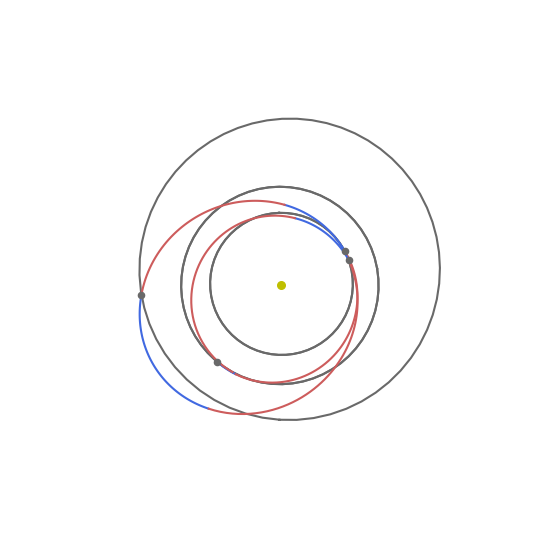

In [8]:
ax = udp.plot(best_x, figsize=(7, 7))
ax.view_init(90, 0)
ax.axis("off");

If we need to disentangle the sequence of the varioous legs we may also subdivide them in subplots:

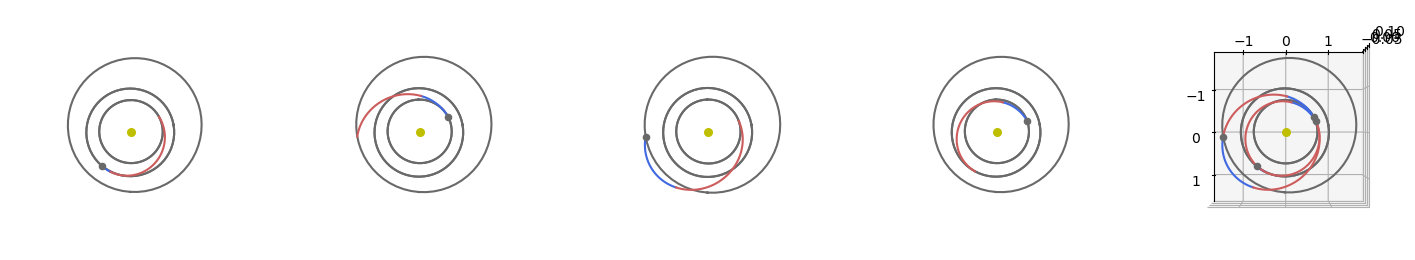

In [9]:
# The figure
fig = plt.figure(figsize=(18,18))

# The single leg plots
for i in range(1,5):
    ax = fig.add_subplot(1, 5, i, projection="3d")
    ax.view_init(90, 0)
    ax = udp.plot(best_x, ax=ax, leg_ids=[i-1])
    ax.axis("off");
    
# All the legs
ax = fig.add_subplot(1, 5, 5, projection="3d")
ax.view_init(90, 0)
ax = udp.plot(best_x, ax=ax)

... or show the various xy, xy, xz views as well as a full 3D one:

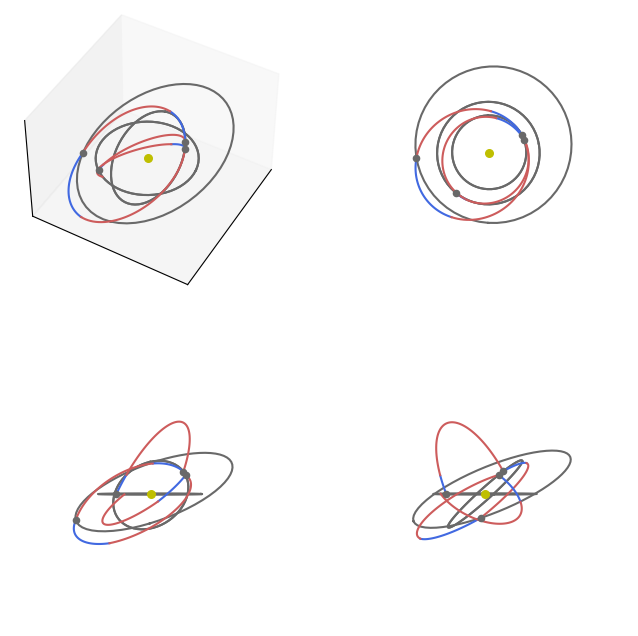

In [10]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(2, 2, 1, projection="3d")
ax = udp.plot(best_x, ax=ax)
ax.view_init(45, 30)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.get_zaxis().set_ticks([])

ax = fig.add_subplot(2, 2, 2, projection="3d")
ax = udp.plot(best_x, ax=ax)
ax.view_init(90, 0)
ax.axis("off")

ax = fig.add_subplot(2, 2, 3, projection="3d")
ax = udp.plot(best_x, ax=ax)
ax.view_init(0, 0)
ax.axis("off")

ax = fig.add_subplot(2, 2, 4, projection="3d")
ax = udp.plot(best_x, ax=ax)
ax.view_init(0, 90)
ax.axis("off");

## Analyzing the trajectory
For a quick analysis of the trajectory we may use the pretty method.

In [11]:
ax = udp.pretty(best_x)


First Leg: earth(jpl_lp) to venus(jpl_lp)
Departure: 2002-08-12T22:54:08.961539 (954.9542703881829 mjd2000) 
Duration: 129.63617646186978days
VINF: 3.954252475620799 km/sec
DSM after 14.390272466933748 days
DSM magnitude: 1.453931272276125m/s

leg no. 2: venus(jpl_lp) to mars(jpl_lp)
Duration: 151.95284197341164days
Fly-by epoch: 2002-12-20T14:10:14.607845 (1084.5904468500578 mjd2000) 
Fly-by radius: 1.410233314260613 planetary radii
DSM after 33.15220374687179 days
DSM magnitude: 15.153363417071064m/s

leg no. 3: mars(jpl_lp) to venus(jpl_lp)
Duration: 292.6348122410418days
Fly-by epoch: 2003-05-21T13:02:20.154347 (1236.5432888234607 mjd2000) 
Fly-by radius: 8.777346309330092 planetary radii
DSM after 134.55855612478126 days
DSM magnitude: 97.48337344576049m/s

leg no. 4: venus(jpl_lp) to earth(jpl_lp)
Duration: 167.33763464044128days
Fly-by epoch: 2004-03-09T04:16:27.931973 (1529.1781010645022 mjd2000) 
Fly-by radius: 2.76338085955769 planetary radii
DSM after 30.706956626414208 days